In [1]:
# Create a dataloaders for the dataset
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from src.data import AminoAcidDataset
from src.model import AminoAcidCNN
from src.train import train_model, evaluate_model


In [ ]:
dataset = AminoAcidDataset('data/amino_acids_augmented.pdb', padding=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=True)

(14, 4)


In [3]:
N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types
criterium = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
"""
def train_model(model: torch.nn.Module, 
                data_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                n_epochs: int) -> dict:
"""

training_dict = train_model(model, train_dataloader, criterium, optimizer, 10)

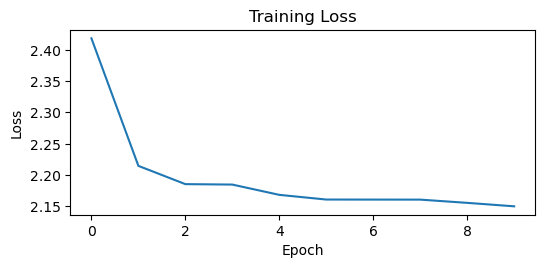

In [11]:
# Plot the training loss
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [5]:
evaluate_model(training_dict["model"], test_dataloader)

{'accuracy': 0.9262061715126038}

### Next Step: Fine-Tuning the Pretrained Model

In the next step, we will continue training the pretrained model using the training dataset. This process, known as fine-tuning, allows the model to further improve its performance by learning from additional data. We will use the same loss function (`criterium`) and optimizer (`optimizer`) as before. The training will be conducted for an additional 20 epochs, and the performance of the model will be evaluated using the test dataset.

In [6]:
# now we can continue training the model
pretrained_model = training_dict["model"]
new_training_dict = train_model(pretrained_model, train_dataloader, criterium, optimizer, 20)

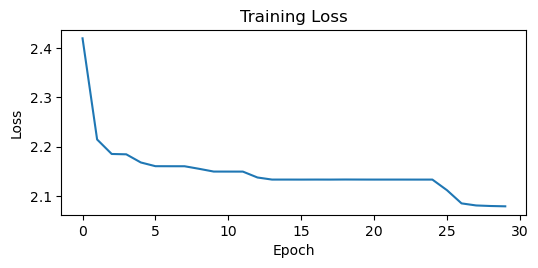

In [12]:
# Plot the training loss of the new training and the previous one
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'] + new_training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [7]:
evaluate_model(new_training_dict["model"], test_dataloader)

{'accuracy': 0.9974778294563293}

In [13]:
# further training
new_pretrained_model = new_training_dict["model"]
new_new_training_dict = train_model(new_pretrained_model, train_dataloader, criterium, optimizer, 70)

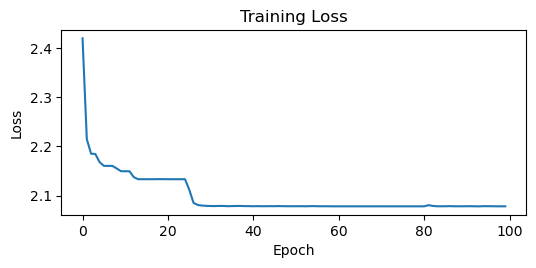

In [15]:
# plot all the training losses
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'] + new_training_dict['total_loss'] + new_new_training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
evaluate_model(new_new_training_dict["model"], test_dataloader)

{'accuracy': 0.9998372793197632}

### Model Performance Summary

In this notebook, we trained and evaluated a Convolutional Neural Network (CNN) model for amino acid classification. Below is a summary of the results:

- **Initial Training:**
    - **Accuracy:** The initial model achieved an accuracy of `0.92` on the test dataset.

- **Fine-Tuning:**
    - **Accuracy:** After fine-tuning the pretrained model for an additional 20 epochs, the model's accuracy on the test dataset was evaluated again and now we reach `0.99`

The fine-tuning process allowed the model to further improve its performance by learning from additional data. The final accuracy of the model after fine-tuning is reported in the subsequent cells.

In [5]:
# iterate over the dataset and make a cake diagram of the amino acids

counner = {"ALA":0, "ARG":0, "ASN":0, "ASP":0, "CYS":0, "GLN":0, "GLU":0, "GLY":0, 
           "HIS":0, "ILE":0, "LEU":0, "LYS":0, "MET":0, "PHE":0, "PRO":0, "SER":0, 
           "THR":0, "TRP":0, "TYR":0, "VAL":0}

for i in range(len(dataset)):
    _,_, residue = dataset[i]
    residue = dataset.one_hot_residues_reverse(residue)
    counner[residue] += 1

plt.Figure(figsize=(6,2.1))
# cake plot
plt.pie(counner.values(), labels=counner.keys(), autopct='%1.1f%%')
plt.title('Amino acid distribution')   


NameError: name 'plt' is not defined

In [6]:

N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# print the first data
#next(iter(dataloader))

Reducing learning rate to 0.0005
Reducing learning rate to 0.00025
Reducing learning rate to 0.000125
Stopping training


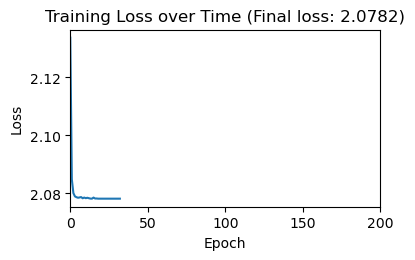

Accuracy: 0.9999186396598816


In [8]:
losses = []
N_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

for epoch in range(N_epochs):  
    # Print replacement for epoch
    print(f'Epoch {epoch + 1}/{N_epochs}', end='\r')
    
    epoch_loss = 0.0
    for coordinates, elements, residue in train_dataloader:
        # Combine coordinates and elements into a single tensor
        input_data = torch.cat((coordinates, elements), dim=2)
        input_data = input_data.unsqueeze(1)  # Add channel dimension
        
        # Forward pass
        output = model(input_data)

        # Calculate the loss
        target = torch.argmax(residue, dim=1)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    

    # if the loss is not decreasing in the last 5, reduce the learning rate
    if len(losses) > 5 and all(losses[-1] >= loss for loss in losses[-5:]):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
            print(f'Reducing learning rate to {param_group["lr"]}')


    # for this we look at the last 10 epochs
    if len(losses) > 11 and all(losses[-1] >= loss for loss in losses[-10:]):
        print('Stopping training')
        break
    print(f'Epoch {epoch + 1}/{N_epochs}, Loss: {epoch_loss:.5f}', end='\r')
    

plt.figure(figsize=(4, 2.3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.xlim(0, N_epochs)
plt.ylabel('Loss')
plt.title('Training Loss over Time (Final loss: {:.4f})'.format(losses[-1]))
plt.show()

accuracy =  Accuracy(task='MULTICLASS', num_classes=20)
model.eval()
accuracy.reset()

for coordinates, elements, residue in test_dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')



In [7]:
# create a hash based on system time
import time
hash = int(time.time())
rounded_accuracy = round(accuracy.compute().item(), 2)
model_name = 'models/{}_amino_acid_cnn_{}.pt'.format(hash, rounded_accuracy)
# Save the model
torch.save(model.state_dict(), model_name)

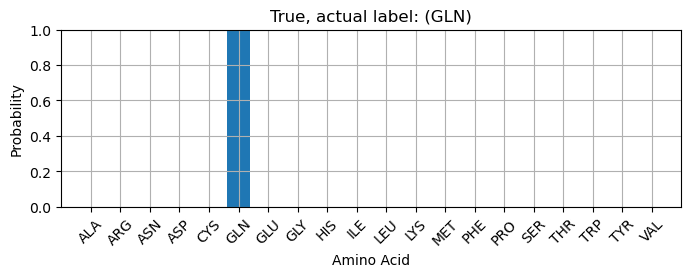

In [8]:
# Load the model
#model = AminoAcidCNN(input_channels=1, input_height=N, input_width=3+M)
#model.load_state_dict(torch.load("/Users/tobias/cell_finder/models/1735130066_amino_acid_cnn_0.98.pt"))

model.eval()
#accuracy = Accuracy()

coordinates, elements, residue = dataset[int(torch.randint(0, len(dataset), (1,)))]
input_data = torch.cat((coordinates, elements), dim=1)
input_data = input_data.unsqueeze(0).unsqueeze(0)
output = model(input_data)


# plot the output of the model
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2.3))
plt.bar(range(20), output.detach().numpy().squeeze())
plt.xticks(range(20), ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                       'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'], rotation=45)
plt.xlabel('Amino Acid')
plt.ylabel('Probability')
# titel is true label
resid_dict = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
is_true = torch.argmax(output) == torch.argmax(residue)

plt.title(f'{is_true}, actual label: ({resid_dict[int(torch.argmax(residue))]})')
plt.ylim(0, 1)
plt.xlim(-1, 20)
plt.grid()
plt.show()


In [10]:
accuracy =  Accuracy(task='MULTICLASS', num_classes=20)
model.eval()
accuracy.reset()

dataloader = test_dataloader
resid_dict = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                          7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                          14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}

for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')

# print out for all the wrong predictions what the actual label was and what the predicted label was
for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    for i in range(len(target)):
        if torch.argmax(output[i]) != target[i]:
            print(f'Actual label: {resid_dict[int(target[i])]}, predicted label: {resid_dict[int(torch.argmax(output[i]))]}')
            print(f'Actual label: {target[i]}, predicted label: {torch.argmax(output[i])}')
            print('')
            print('')

Accuracy: 0.9999186396598816
Actual label: ILE, predicted label: LEU
Actual label: 9, predicted label: 10




In [47]:
aa_mf = {
    "ALA": "C3NO2",
    "ARG": "C6N4O2",
    "ASN": "C4N2O3",
    "ASP": "C4NO4",
    "CYS": "C3NO2S",
    "GLN": "C5N2O3",
    "GLU": "C5NO4",
    "GLY": "C2NO2",  # Corrected
    "HIS": "C6N3O2",
    "ILE": "C6NO2",
    "LEU": "C6NO2",
    "LYS": "C6N2O2",
    "MET": "C5NO2S",
    "PHE": "C9NO2",
    "PRO": "C5NO2",
    "SER": "C3NO3",
    "THR": "C4NO3",
    "TRP": "C11N2O2",
    "TYR": "C9NO3",
    "VAL": "C5NO2"
}



In [ ]:
# read rep1_frame24.pdb and extract the residues and write them to a new pdb file with END seperation for my dataset
# I will use the following code to extract the residues from the pdb file
# the new file is called demo.pdb

import os

def extract_residues(pdb_file: str, output_file: str) -> None:
    # For every time the residue changes, write END to the file, leave all Hydrogens out
    # WHEN THE ORIGINAL SAYS END, WRITE END AND STOP WRITING
    RESIDUE = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
               'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
               'THR', 'TRP', 'TYR', 'VAL']
    
    with open(pdb_file, 'r') as f:
        with open(output_file, 'w') as out:
            residue = None
            for line in f:
                if line.startswith('ATOM'):
                    current_residue = line[17:20].strip()
                    if residue is None:
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if residue != current_residue:
                        if residue in RESIDUE:
                            out.write('END\n')
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if line[12:14].strip()[0] != 'H':
                        out.write(line)
                elif line.startswith('END'):
                    if residue in RESIDUE:
                        out.write('END\n')
                    break

extract_residues('rep1_frame24.pdb', 'demo.pdb')

# from demo create a dataset demo augmented where for each residue we add 10 rotations of the residue
# I will use the following code to augment the dataset

def center_residue_to_first_atom(coordinates: torch.Tensor) -> torch.Tensor:
    # center the coordinates to the first atom
    first_atom = coordinates[0]
    centered_coordinates = coordinates - first_atom
    
    return centered_coordinates

def rotate_residue(coordinates, phi, psi, theta):
    # center the coordinates to the first atom
    centered_residue = center_residue_to_first_atom(coordinates)
    phi, psi, theta = torch.deg2rad(torch.tensor(phi)), torch.deg2rad(torch.tensor(psi)), torch.deg2rad(torch.tensor(theta))
    # rotate the molecule by phi degrees around the x-axis
    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, torch.cos(phi), -torch.sin(phi)],
                                    [0, torch.sin(phi), torch.cos(phi)]])
    rotated_residue = torch.matmul(centered_residue, rotation_matrix)
    # rotate the molecule by psi degrees around the y-axis
    rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
                                    [0, 1, 0],
                                    [-torch.sin(psi), 0, torch.cos(psi)]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)
    # rotate the molecule by theta degrees around the z-axis
    rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                    [torch.sin(theta), torch.cos(theta), 0],
                                    [0, 0, 1]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)

    return rotated_residue


def augment_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []

    for i in range(len(dataset)):
        coordinates, elements, residue = dataset[i]
        for _ in range(3):
            phi, psi, theta = torch.randint(0, 360, (1,)).item(), torch.randint(0, 360, (1,)).item(), torch.randint(0, 360, (1,)).item()
            # center the coordinates to the first atom
            rotated_coordinates = rotate_residue(coordinates, phi, psi, theta)
            for j in range(len(rotated_coordinates)):
                # pdb format is ATOM  1    C ALA A   1     1.000   2.000   3.000  1.00  0.00
                augmented_lines.append(f'ATOM {j + 1:6d} {element_to_name[int(torch.argmax(elements[j]))]:>2}   {residue_to_name[int(torch.argmax(residue))]:>3}     1    {rotated_coordinates[j][0]:8.3f}{rotated_coordinates[j][1]:8.3f}{rotated_coordinates[j][2]:8.3f}    1.00  0.00\n')
            augmented_lines.append('END\n')
    with open(output_file, 'w') as f:
        f.writelines(augmented_lines)


dataset = AminoAcidDataset('data/amino_acids.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_augmented.pdb')






In [3]:
from src.augmentation import augment_dataset
from src.data import AminoAcidDataset


dataset = AminoAcidDataset('data/amino_acids.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_augmented.pdb',1)

ValueError: 'H' is not in list

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.6550,  1.3570],
        [ 0.4560,  2.1960,  1.3210],
        [ 1.8570,  2.6070,  0.6920],
        [ 3.2400,  2.0510,  1.7160],
        [ 4.5790,  2.7540,  0.8150],
        [-0.7220,  0.2220,  2.3790],
        [-0.3440, -0.3000,  3.4630]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.6550,  1.3570],
        [ 0.4560,  2.1960,  1.3210],
        [ 1.8570,  2.6070,  0.6920],
        [ 3.2400,  2.0510,  1.7160],
        [ 4.5790,  2.7540,  0.8150],
        [-0.7220,  0.2220,  2.3790],
        [-0.3440, -0.3000,  3.4630]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.8807,  1.2226],
        [ 0.4560,  2.3920,  0.9196],
        [ 1.8570,  2.6876,  0.2288],
        [ 3.2400,  2.3178,  1.3338],
        [ 4.5790,  2.8537,  0.3244],
        [-0.7220,  0.6317,  2.3043],
        [-0.3440,  0.3059,  3.4625]])


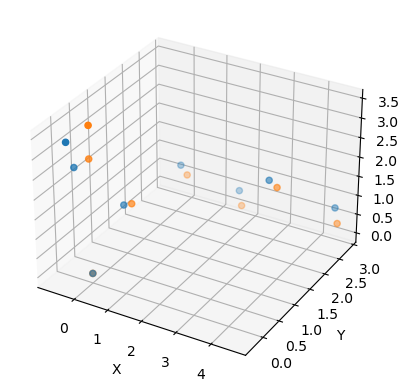

In [ ]:
# rotate this molecule:
residue = torch.tensor([[ -5.0390,  22.5140, -14.6070],
                        [ -4.7540,  23.1690, -13.2500],
                        [ -4.5830,  24.7100, -13.2860],
                        [ -3.1820,  25.1210, -13.9150],
                        [ -1.7990,  24.5650, -12.8910],
                        [ -0.4600,  25.2680, -13.7920],
                        [ -5.7610,  22.7360, -12.2280],
                        [ -5.3830,  22.2140, -11.1440]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_residue(coordinates):

    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')



# center the coordinates to the first atom
centered_residue = center_residue_to_first_atom(residue)
print(centered_residue)

plot_residue(centered_residue)
# rotate the molecule by 90 degrees around the z-axis
theta = 10
theta = torch.deg2rad(torch.tensor(theta))
rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                [torch.sin(theta), torch.cos(theta), 0],
                                [0, 0, 1]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)

# rotate the molecule by 90 degrees around the x-axis
#phi = 30
#phi = torch.deg2rad(torch.tensor(phi))
#rotation_matrix = torch.tensor([[1, 0, 0],
#                                [0, torch.cos(phi), -torch.sin(phi)],
#                                [0, torch.sin(phi), torch.cos(phi)]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)


# rotate the molecule by 90 degrees around the y-axis
#psi = 45
#psi = torch.deg2rad(torch.tensor(psi))
#
#rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
#                                [0, 1, 0],
#                                [-torch.sin(psi), 0, torch.cos(psi)]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)

def rotate_residue(coordinates, phi, psi, theta):
    # center the coordinates to the first atom
    centered_residue = center_residue_to_first_atom(coordinates)
    phi, psi, theta = torch.deg2rad(torch.tensor(phi)), torch.deg2rad(torch.tensor(psi)), torch.deg2rad(torch.tensor(theta))
    print(centered_residue)
    # rotate the molecule by phi degrees around the x-axis
    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, torch.cos(phi), -torch.sin(phi)],
                                    [0, torch.sin(phi), torch.cos(phi)]])
    rotated_residue = torch.matmul(centered_residue, rotation_matrix)
    # rotate the molecule by psi degrees around the y-axis
    rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
                                    [0, 1, 0],
                                    [-torch.sin(psi), 0, torch.cos(psi)]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)
    # rotate the molecule by theta degrees around the z-axis
    rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                    [torch.sin(theta), torch.cos(theta), 0],
                                    [0, 0, 1]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)

    return rotated_residue

final = rotate_residue(residue, 10,0,0)
print(final)
plot_residue(final)

In [67]:
dataset = AminoAcidDataset('demo_augmented.pdb')
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

In [ ]:
# read rep1_frame24.pdb and extract the residues and write them to a new pdb file with END seperation for my dataset
# I will use the following code to extract the residues from the pdb file
# the new file is called demo.pdb

import os

def extract_residues(pdb_file: str, output_file: str) -> None:
    # For every time the residue changes, write END to the file, leave all Hydrogens out
    # WHEN THE ORIGINAL SAYS END, WRITE END AND STOP WRITING
    RESIDUE = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
               'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
               'THR', 'TRP', 'TYR', 'VAL']
    
    with open(pdb_file, 'r') as f:
        with open(output_file, 'w') as out:
            residue = None
            for line in f:
                if line.startswith('ATOM'):
                    current_residue = line[17:20].strip()
                    if residue is None:
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if residue != current_residue:
                        if residue in RESIDUE:
                            out.write('END\n')
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if line[12:14].strip()[0] != 'H':
                        out.write(line)
                elif line.startswith('END'):
                    if residue in RESIDUE:
                        out.write('END\n')
                    break

extract_residues('rep1_frame24.pdb', 'demo.pdb')

# from demo create a dataset demo augmented where for each residue we add 10 rotations of the residue
# I will use the following code to augment the dataset

def center_residue_to_first_atom(coordinates: torch.Tensor) -> torch.Tensor:
    # center the coordinates to the first atom
    first_atom = coordinates[0]
    centered_coordinates = coordinates - first_atom
    return centered_coordinates



def augment_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []

    for i in range(len(dataset)):
        coordinates, elements, residue = dataset[i]
        print(coordinates)
        break
     
        for _ in range(1):
            # center the coordinates to the first atom
            rotated_coordinates = center_residue_to_first_atom(coordinates)
            for j in range(len(rotated_coordinates)):
                # pdb format is ATOM  1    C ALA A   1     1.000   2.000   3.000  1.00  0.00
                augmented_lines.append(f'ATOM {j + 1:6d} {element_to_name[int(torch.argmax(elements[j]))]:>2}   {residue_to_name[int(torch.argmax(residue))]:>3}     1    {rotated_coordinates[j][0]:8.3f}{rotated_coordinates[j][1]:8.3f}{rotated_coordinates[j][2]:8.3f}    1.00  0.00\n')
            augmented_lines.append('END\n')
    with open(output_file, 'w') as f:
        f.writelines(augmented_lines)


dataset = AminoAcidDataset('demo.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'demo_augmented.pdb')




def rotated_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                       'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []


tensor([[ -5.0390,  22.5140, -14.6070],
        [ -4.7540,  23.1690, -13.2500],
        [ -4.5830,  24.7100, -13.2860],
        [ -3.1820,  25.1210, -13.9150],
        [ -1.7990,  24.5650, -12.8910],
        [ -0.4600,  25.2680, -13.7920],
        [ -5.7610,  22.7360, -12.2280],
        [ -5.3830,  22.2140, -11.1440]])


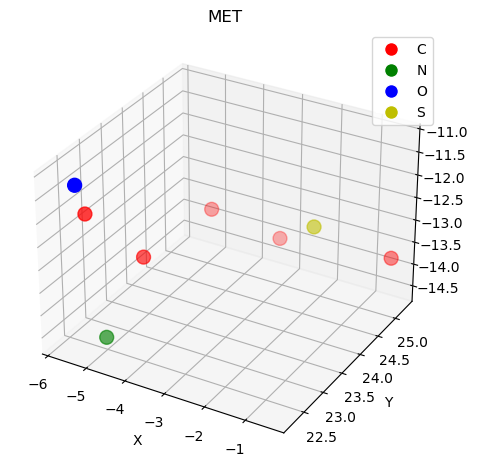

In [8]:
# plot an example of the data residue 

coordinates, elements, residue = dataset[0]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

element_colors = { 0: 'r', 1: 'g', 2: 'b', 3: 'y' }
# coordinates and colored by the element type with a legend
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=[element_colors[int(torch.argmax(e))] for e in elements], s=100)
# fix a legend with the right colors for the elements
ax.set_xlabel('X')
ax.set_ylabel('Y')


residue_dict = {1:"ALA", 2:"ARG", 3:"ASN", 4:"ASP", 5:"CYS", 6:"GLN", 7:"GLU",
                8:"GLY", 9:"HIS", 10:"ILE", 11:"LEU", 12:"LYS", 13:"MET", 14:"PHE", 
                15:"PRO", 16:"SER", 17:"THR", 18:"TRP", 19:"TYR", 20:"VAL"}
plt.title(residue_dict[int(torch.argmax(residue))+1])
element_dict = {0:"C", 1:"N", 2:"O", 3:"S"}

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='C'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='N'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='O'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='y', markersize=10, label='S')])
plt.tight_layout()
plt.show()
